# はじめに

本文書は，日本コンピュータ外科学会によって開催されたJSCAS AI Challengeという機械学習のコンペティションに参加したときの記録です．

https://www.jscas.org/business/2020/09/c83412be4feb3ca543c74d759fee400c073cda07.html


この文書では大きく分けて2つの話題，コンペティションまでに行ったこと，コンペティション後に他の人の発表を参考に改善を試みたこと，について書きます．

コンペティションの発表までに行ったこととしては，モデルの選定，損失関数の調査，パラメータチューニングなどがあります．

また，アンサンブル学習を行い，結果的にこれが最も効果のある学習方法でした．
今回は主にこのアンサンブル学習について実際にどのように行ったのか書きます．

コンペティション後には，他の人の発表を参考にしながら改善を試みました．
こちらについては結果的に大きな精度の向上は達成できませんでしたが，
いくつか実験を行ったので記録として書きます．


# コンペティション概要

先に述べた通り，参加したコンペティションは，日本コンピュータ外科学会によって開催されたJSCAS AI Challengeという名前の機械学習コンペティションです．

コンペティションで要求されるタスクは，内視鏡外科手術画像の中から術具の先端部分を自動で識別せよ，というセマンティックセグメンテーションタスクです．

具体的には超音波凝固切開装置と呼ばれる医療器具が画像に写っており，
切開を行う先端部分を認識することが求められていることです．

また，この超音波凝固切開装置には新旧の二種類が存在し，それを扱うか否かによって以下の2つのタスクレベルに分けられていました．

- レベル1：新旧の区別無く術具の先端を認識
- レベル2：新旧の区別（クラスタリング）を行いかつ，術具の先端を認識

今回私はレベル1のみを行いました（機械学習初心者でクラスタリングまで手が回らなかったためです）．

## 評価指標

評価指標にはF値を使います．
セマンティックセグメンテーションでは各ピクセルごとに正誤判定ができます．
正誤判定において正と判定されたもののうち実際に正であるものの割合をprecision,
実際に正であるもののうち正と判定されたものの割合をrecallと呼び，
precisionとrecallの調和平均をF値と呼びます．

Precision, Recallの定義を具体的に示します。

||真の結果・正|真の結果・負|
|----------|-------------|--------------|
|予測結果・正|True Positive(TP)|False Positive(FP)|
|予測結果・負|False Negattve(FN)|True Negative(TN)|

表に示すように、予測結果と真の結果の組み合わせ、TP,FP,FN,TNが与えられるとき、正解率（Accuracy）, 適合率（Precision）、再現率（Recall）,F値(F-measure)はそれぞれ以下の式で与えられます。

$Accuracy=\frac{TP+TN}{TP+FP+TN+FB}$

$Precision=\frac{TP}{TP+FP}$

$Recall=\frac{TP}{TP+FN}$

$F=\frac{2 \cdot Recall \cdot Precision}{Recall + Precision}$

## データセット

データセットは以下の通りです．

- トレーニング画像
    - 325枚
- テスト画像
    - 75枚
- 検証画像
    - 150枚（新：75枚，旧：75枚）
    - セグメンテーションの難易度毎にeasy, middle, hardに分類される

以下に表示してあるのが，トレーニング画像のサンプルです．

![sample_training](./jscas_ai_challenge_2020_data/sample_training.png)

また，すべての画像には対応するラベル画像があり，
ラベル画像は背景(0)，旧(1)，新(2)が各ピクセルに割り当てられています．

画像にラベル画像をマスクするとこのような形になります．
（右側の画像では，術具の先端が黄色で塗られています）

![sample_label](./jscas_ai_challenge_2020_data/sample_label.png)

    
ラベルを含む画像データはJSCASのページに公開されています．
http://bit.ly/ai20data
    

# 手法

本チャレンジで実施した手法は以下の通りです．

- どのようにデータの前処理をおこなったか
- どのような識別器を用いたか
    - モデル
    - 損失関数
    - 最適化アルゴリズム
- どのように術具の領域を推定したか


## 前処理

トレーニング画像325枚に対して，精度向上を目的として,いくつかの前処理を行います．
- mixup
- Data Augumentation(DA)

### mixup

mixupはトレーニング用の画像を複数枚混ぜた画像を学習に用いる手法です．

今回はトレーニング画像からランダムに二枚の画像を選択して混合する方法をとります．

数式で表現すると，以下のようになります．

$\lambda \times image_1 + (1 - \lambda) \times image_2$  
$\lambda = Beta(\alpha, \alpha)$

今回$\alpha$の値は0.4に設定しました．

### DataAugmentation(以下DA)

DAではトレーニング画像を加工して，その画像を学習に用います．

今回行ったDAは以下の通りです．

- 平行移動，反転などのアフィン変換
- 明るさ
- 色の濃度の変更


kerasには `ImageDataGenerator`という画像加工用のクラスが用意されていて，これを用いてDAを行いました．

実際に書くときは以下のような書き方で，複数の画像処理を行うことができます．

```python:da.py
ImageDataGenerator(
    brightness_range=(0.5, 1.5)
)
```

## 学習モデル

モデルはDeepLabv3+を用いました．
    
DeepLabv3+はGoogleが2018年に出したモデルで，空間ピラミッドプーリング
モジュールと、Encoder-Decoder モデルの利点を組み合わせたモデルです．
詳しくは論文やQiitaのまとめなどを参照してください．
https://qiita.com/mine820/items/14e7c556b358dbc4ee9a

他にセマンティックセグメンテーションにおいて有名なモデルとしてU-netがあります．
U-netとDeepLabv3+で学習速度を比較するとDeepLabv3+のほうが早く，高速にイテレーションを回すことができます．

ちなみに他のコンペティション参加者の多くはU-netを使って私より高い精度を出していました．
あまりモデル差が出ないのは事前に想像していた印象と違っていたので，これは勉強になりました．

参考にしたコードからの変更点としては，ドロップアウト率を0.5に変更したこと，があります．

### 損失関数

損失関数については，いくつかの調査を行いました．
セマンティックセグメンテーションでは，認識対象の領域と背景との比率が大きく異る場合があります．
今回扱うデータにおいても，術具の先端という非常に小さい領域が認識対象です．
そのような場合には一般的なbinary cross entroyよりもセマンティックセグメンテーションに特化した損失関数を用いると，精度が向上する場合があります．

今回は以下のような損失関数を検討しました．

- binary crossentropy
- sigmoid focal loss
- focal tversky
- boundary loss

結果としてfocal tverskyを基本的に使用しました．
後述するアンサンブル学習の関係で，一部の識別器ではboundary loss関数をfocal tverskyと併用している場合もあります．

こちらもモデル同様ですが，他の参加者は一般的なbinary crossentropyを使っていました．

おそらくですが，最初にボトルネックになるのはデータの多様性といった問題で，
それを解決したあとで初めてモデルや損失関数の変更が効いてくるのではないかなと思います．

## アンサンブル学習

複数の弱識別器を組み合わせて学習・推論を行う機械学習の手法をアンサンブル学習といいます．

今回は複数の分類器の出力の平均を取ることでより良い分類（セグメンテーション）結果を得る，という形でアンサンブル学習の考え方を取り入れています．


コンペティションに提出した際に使った識別器は以下の３つです．
- DA有り($y_1$)
- DA無し($y_2$)
- 損失関数の違い($y_3$)

上記の3つの結果を用いて、最終的なセマンティックセグメンテーションの結果Lは以下の式で得ることができます。

$L = [\frac{y_1 + y_2 + y_3}{3}+0.5]$
    

# 評価

実際の推定結果を比較して，アンサンブル学習の効果を確かめます．


```python:train.py
# 疑似コードですので実行しても動きません

# DA
# セマンティックセグメンテーションの場合はラベルも画像のため，
# 平行移動や回転などのアフィン変換はラベル画像も一緒に変換してあげる必要があります
data_augmentation()

# create model
model1 = DeepLabv3()
model2 = DeepLabv3()
model3 = DeepLabv3()

# training
# 実際には識別器(model1, 2, 3)はそれぞれ別に学習しています
model1.train()
model2.train()
model3.train()

# estimation
result1 = predict(model1)
result2 = predict(model2)
result3 = predict(model3)
result = (result1+result2+result3)/3.0

```


学習した識別器の性能を確かめるために，テストデータを用いて，識別器の推定精度を算出します．
テストデータは識別難易度ごとにeasy,middle,hardに分かれており，それぞれについて推定精度を出します．
3つの識別器それぞれの推定結果とアンサンブル学習の結果を図示しています．
(hardについては，認識することが困難であったため，図から除外しています．)

![result](./jscas_ai_challenge_2020_data/compare4.png)

- FT+DA（青色）    
- FT（橙色）       
- FT+BL（緑色）    
- ensenbled（赤色）

青色のグラフはfocal tversky + data augmentation,
橙色のグラフはfocal tversky,
緑色のグラフはfocal tversky + boundary loss,
赤色のグラフはアンサンブル学習の結果，
となっています．

アンサンブル学習に用いる識別器の選択は，今回はヒューリスティックに行いました．


アンサンブル学習によってすべての難易度で二番目の精度を達成していることがわかります．

それぞれの識別器に得意不得意なデータがありますが，アンサンブル学習を行うことによって，平均的に優秀な識別器を作成可能である，ということがわかりました．

# 評価の結果に基づいた改良

ここからはコンペティション発表後に行った実験について，いくつか紹介します．
結論から書くと識別性能に大きく寄与するような学習方法は発見できませんでしたが，記録として残しておこうと思います．
（特に識別できていなかったhardの画像を識別可能になることを期待したのですが，うまくいきませんでした）

さて，行ったこととしては，

- fog, DefocusBlurなどの画像処理をDAとして行う
- RGBチャンネルに加えて，RGBチャンネルに前処理を施したデータを4つ目以降の特徴量として扱う
- 上下反転のみでDAを行う

といったものがあります．




## fog, DefocusBlurなどの画像処理をDA

セグメンテーション精度が悪かった画像として，切開で焼き切るときに発生する煙で曇っていたり，カメラのピントがずれているものが多く見られました．
とりわけテストデータの識別難易度hardはそのような画像が多く，これが識別困難の原因である可能性があります．

そのような画像をDAで生成して識別器を訓練することで精度が向上するのではないだろうか，というのがこの試みです．

DAにはimgaugライブラリを用いました．
Fog(煙っぽい処理)やDefocusBlur(ピントのズレ)関数が用意されていて，簡単に画像を加工することができます．

以下に具体例を示します．

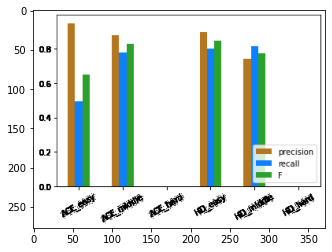

In [31]:
import imgaug.augmenters as iaa
import numpy as np
import cv2

aug = iaa.SomeOf((0, None), [
  iaa.imgcorruptlike.Fog(severity=2), # kemuri
  iaa.AddToBrightness((-30, 30)),
  iaa.imgcorruptlike.DefocusBlur(severity=2), # camera no pinto
  iaa.Affine(scale=(0.8, 1.2), translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}),
  iaa.Rotate((-45, 45))
  ])

# 実際に画像を加工してみる
img = cv2.imread('jscas_ai_challenge_2020_data/bar.png', cv2.IMREAD_COLOR)
img_aug = aug.augment_image(img)

# 画像を出力するコード
import matplotlib.pyplot as plt
plt.imshow(img)

`SomeOf`は渡した処理のうちいくつかを適用します．
他にも順番に処理を適用する`Sequential`や，
渡した処理のうち一つだけを適用する`OneOf`など便利な関数があります．

結果をグラフで示します．

![result](./jscas_ai_challenge_2020_data/bar2.png)
![compare](./jscas_ai_challenge_2020_data/compare5.png)

アンサンブル学習の結果と比較すると，すべての難易度で精度が下がっています．

原因としては，

- DAによる画像加工が強すぎた
- 適用されるフィルターがランダムで，求めるような画像に加工されていなかった可能性

などが考えられます．

次に行う検証としては`Sequential`などを使って一つずつフィルターを適用し，どのフィルターで精度が向上するのか確かめる，といったことが考えられると思います．

## データに合わせた特徴量の追加

内視鏡手術画像の特徴として内臓からなる赤色が多くを占めるというものがあります．
対して術具先端は黒に近い色で構成されているため，RGB空間でうまく分離できるのではないかと考えました．
RGBチャネルのみを入力特徴量として扱うことで，内臓と術具先端を分けることができるのが理想ですが，実際にはそうでないこともあるため，明示的に新しい特徴量を導入することでうまくいかないかという試みです．

今回は目的の処理を行うためにopencvのpythonライブラリを使いました．
`threshold`という関数があり閾値処理をして画像の二値化ができます．

具体例をコードで示します．

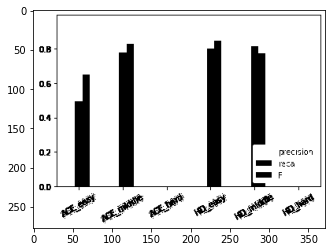

In [48]:
import cv2
img = cv2.imread('jscas_ai_challenge_2020_data/bar.png', cv2.IMREAD_COLOR)

# しきい値で切り上げ
img_threshold = cv2.threshold(img[:,:,0], 100, 255, cv2.THRESH_BINARY)[1]

import matplotlib.pyplot as plt
plt.imshow(img_threshold, cmap='gray')

`thoreshold`関数の第一引数に渡す画像のピクセル値は0~255の範囲にあります．
ピクセル値が第二引数で指定した値以上の場合，そのピクセル値を第三引数の値にします．
第四引数は数値の切り上げ方のオプションで，グラデーションで変化させることもできます．

詳しくは以下のリンクに詳細な解説が書いてあります．
http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html



結果をグラフで示します．

![result](./jscas_ai_challenge_2020_data/bar3.png)
![compare](./jscas_ai_challenge_2020_data/compare6.png)

アンサンブル学習の結果と比較すると，難易度がeasyのデータに対してはやや精度が向上する結果になりました．
しかし，難易度がmiddleのデータに関しては精度が低下しています．

今回は`cv2.threshold()`の閾値を，術具と内臓を分離できそうなところ，という観点から自分で決めました．
そのため，より良い閾値を探索するアルゴリズムを用いて閾値を決めることで，結果が改善する可能性があります．

## 上下反転のDA

実際にどのようなDAが効果的なのか，という疑問から試してみた一例です．

これもopencvの関数`cv2.flip()`を用いました．

具体例は以下の通りです．

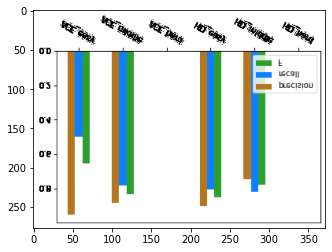

In [51]:
import cv2
img = cv2.imread('jscas_ai_challenge_2020_data/bar.png', cv2.IMREAD_COLOR)

# flipCode: {0(上下反転),1(左右反転),-1(上下左右反転)}
flipCode = 0
img_flip = cv2.flip(img, flipCode) 

import matplotlib.pyplot as plt
plt.imshow(img_flip, cmap='gray')

この実験で使う識別器は，与えられたデータのまま学習を行っています．
推論の段階で，検証データ対してflipを行う/行わないの二通りを試して，
精度で比較します．

実際の精度は以下のようになりました．

|            | flip(上下反転) | no flip      |
|:-----------|------------:|:------------:|
| ACE_easy   | 0.186624    | 0.378732     |
| ACE_middle | 0.640430    | 0.408440     |
| HD_easy    | 0.529929    | 0.488181     |
| HD_middle  | 0.434052    | 0.356442     |


flipしたデータではACE_easyだけ精度が下がり，他の難易度では精度が向上しました．

おそらく，データの絶対数が少なく，術具の向きに対する汎化性能を確保できなかったのではないでしょうか．


# まとめ

本文書では，日本コンピュータ外科学会によるJSCAS AI Challengeコンペティションに参加した際にどういう実験を行ったのか，についてまとめました．

今回のチャレンジでは，DeepLabv3+を用いてセマンティックセグメンテーションを行う手法を実装しました．

試したいくつかの手法の中で効果的だったのは，アンサンブル学習で，三つの識別器をアンサンブル学習させることで平均的に優秀な識別器ができました．

コンペティション参加後には，識別困難だった画像に似せて加工するDAや，
予め閾値によって大まかに術具と背景をわけた画像をRGB画像とともに特徴量に加えることを試しましたが，これらによって精度向上することはできませんでした．

コンペティションの上位勢を参考にするに，いろいろなフィルターを用いたDAは有効だと考えられるので，上記の試みに加えいろいろなフィルターを適用することで，より良い精度が得られる可能性は残っていると考えられます．

# 参考

- [JSCAS AI Challenge - 学会事業 | 一般社団法人 日本コンピュータ外科学会](https://www.jscas.org/business/2020/09/c83412be4feb3ca543c74d759fee400c073cda07.html)
- [Qiita - DeepLab v3+（意訳）](https://qiita.com/mine820/items/14e7c556b358dbc4ee9a)